# CLIP을 통한 성능 확인 original

In [239]:
import gradio as gr
import clip,torch
import requests
from PIL import Image
import numpy as np
import torch
from io import BytesIO

url = 'https://i.pinimg.com/564x/47/b5/5d/47b55de6f168db65cf46d7d1f0451b64.jpg'
text =["a diagram", "a dog", "a cat",'notebook','room','door','computer']

label = ["Science",
"News",
"Food",
"Blog",
"Tech",
"Informative",
"Comedy,Entertainment",
"Entertainment",
"Automobile",
"Tech,Informative",
"Automobile,Comedy",
"VideoGames",
"Food,Entertainment",
"Blog,Comedy",
"Comedy,Informative",
"Tech,Comedy",
"Comedy",
"Blog,Science",
"Blog,Entertainment",
"Entertainment,Comedy",
"Tech,News",
"Entertainment,Blog"]

response = requests.get(url)
image_bytes = response.content

"""Gets the embedding values for the image."""
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

#Url 이미지 전처리.
preprocess_image = preprocess(Image.open(BytesIO(image_bytes))).unsqueeze(0).to(device)
# torch.Size([1, 3, 224, 224])


# 텍스트 tokenize
text_token = clip.tokenize(text).to(device)
# torch.Size([7, 77])
label_token = clip.tokenize(label).to(device)
# torch.Size([22, 77])

# output.dtype : torch.float32
def cosine_sim(x_emb,label_emb : torch.tensor) -> torch.tensor: # vector -> scalar 
    x_emb = x_emb.view(512)
    
    scores = torch.dot(x_emb,label_emb[0].view(512)).view(1)
    
    for i in range(1,22):
        label_emb_i = label_emb[i].view(512)
        score = torch.dot(x_emb,label_emb_i)
        score = score.view(1)
        scores = torch.cat([scores,score],dim=0)

    return scores

with torch.no_grad():
    # encoding
    image_features = model.encode_image(preprocess_image)
    # torch.Size([# of img, 512]  1
    text_features = model.encode_text(text_token)
    # torch.Size([# of text, 512] 1
    label_features = model.encode_text(label_token)
    # torch.Size([# of text, 512] 22
    
    
    logits_per_image, logits_per_text = model(preprocess_image,text_token)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()
    
    ## similarity of image
    img_sim = cosine_sim(image_features,label_features)
    text_sim = cosine_sim(text_features,label_features)    

    print('labels probability',probs)
    # return text_features,image_features,probs

def softmax(img_sim):
    return torch.exp(img_sim) / torch.sum(torch.exp(img_sim))



labels probability [[1.]]


In [103]:
model

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [125]:
model.visual.transformer.resblocks

Sequential(
  (0): ResidualAttentionBlock(
    (attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
    )
    (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (mlp): Sequential(
      (c_fc): Linear(in_features=768, out_features=3072, bias=True)
      (gelu): QuickGELU()
      (c_proj): Linear(in_features=3072, out_features=768, bias=True)
    )
    (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (1): ResidualAttentionBlock(
    (attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
    )
    (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (mlp): Sequential(
      (c_fc): Linear(in_features=768, out_features=3072, bias=True)
      (gelu): QuickGELU()
      (c_proj): Linear(in_features=3072, out_features=768, bias=True)
    )
    (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )


# youtube crawling한 걸 clip으로 돌리기


### youtube SERP data

In [240]:
# Import Library
import requests
from bs4 import BeautifulSoup
import time
import urllib.request
from selenium.webdriver import Chrome
import re
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
import datetime as dt
from selenium.webdriver.common.by import By

from urllib import parse

from selenium import webdriver


driver = Chrome()
url = 'https://www.youtube.com'
driver.get(url)

time.sleep(7) # 여기서 시간 많이줘야 로딩댐.

#################################################################################
### youtube page scroll   : java script로 동적 구성되어있기때문에, 아래로 내려줘서 정보를 로딩
#################################################################################

body = driver.find_element(By.CSS_SELECTOR, 'body')
for _ in range(5): # 5번 반복.
    for _ in range(7): # 7번 내리고 1초 쉬고,
        body.send_keys(Keys.PAGE_DOWN)
    time.sleep(1.5)



#################################################################################
### get image,title,url - selenium이나 bs4를 이용해서 크롤링.
#################################################################################

time.sleep(3) # 끝나고 시간주기? soup으로 잘 가져올 수 있게?

try:
    soup = BeautifulSoup(driver.page_source)
    
    imgs_list = soup.select('div#contents div#content') # tag이름#ID이름
    img_urls = []
    result = []
    for img in imgs_list:
        try:
            xx =img.find('img') # img tag를 찾는다.
            ## 마찬가지로 xx도 bs4.element.Tag이다.
            print(xx['src'].split('?')[0]) ### img 존재하는거 하나 가져오기.
            img_url = xx['src'].split('?')[0] 


            a_tag = img.select('a#video-title-link')[0] ## soup에서 가져온 정보인데, list형태라서 안에 str을 가져와야해서 풀어줘야함.
            # type은 bs4.element.Tag이다.
            link = parse.urljoin(url,a_tag.get('href'))
            print('link ',link)
            
            title = a_tag['aria-label']
            print('title',title)

            result.append([link,title,img_url])
            
        except:
            print('image error')
except:
    print('error exists')

driver.quit()

print('크롤링한 페이지 개수 :',len(result))
# url title jpg

https://i2.ytimg.com/vi/ofG83s2gIFg/0.jpg
image error
https://i.ytimg.com/vi/HqN3zXNat3c/hq720.jpg
link  https://www.youtube.com/watch?v=HqN3zXNat3c
title [오늘 이 뉴스] "이게 진실" 국방부 문건에 발칵 "극단적인 유튜버 낚시 용어를.." (2023.10.05/MBC뉴스) 게시자: MBCNEWS 조회수 40,951회 1시간 전 4분 15초
https://i.ytimg.com/vi/hT-c8oEwyd0/hq720.jpg
link  https://www.youtube.com/watch?v=hT-c8oEwyd0
title [항저우AG] 박세웅 '막고' 노시환 '치고'  운명의 한일전 2대0 승리!!! 게시자: 엠빅뉴스 조회수 126,876회 2시간 전 2분 18초
https://i.ytimg.com/vi/Es0Qst5BItU/hq720.jpg
link  https://www.youtube.com/watch?v=Es0Qst5BItU
title [나는 SOLO LIVE] 16기 역대급 매운맛 출연자들을 라이브로 생생하게 만날 수 있는 절호의 기회! 놓치지 마세요~ 게시자: 촌장엔터테인먼트TV 조회수 1,042,173회 스트리밍 시간: 16시간 전 1시간 17분
https://i.ytimg.com/vi/pYcbqdESGQw/hq720.jpg
link  https://www.youtube.com/watch?v=pYcbqdESGQw
title 갈매기가  새우깡인줄? 게시자: 엄영순 조회수 513회 3일 전 1초
https://i.ytimg.com/vi/LN8P8yNYF4o/hq720.jpg
link  https://www.youtube.com/watch?v=LN8P8yNYF4o
title 제주 전역에서 "이제 없어"…심상치 않음 느낀 도민들 '발칵' #뉴스다 / JTBC News 게시자: JTBC News 조회수 583,658회 1일 전 6분 39초


# clip module화 시키기. 

In [8]:
import gradio as gr
import clip,torch
import requests
from PIL import Image
import numpy as np
import torch
from io import BytesIO

label = ["Science",
"News",
"Food",
"Blog",
"Tech",
"Informative",
"Comedy,Entertainment",
"Entertainment",
"Automobile",
"Tech,Informative",
"Automobile,Comedy",
"VideoGames",
"Food,Entertainment",
"Blog,Comedy",
"Comedy,Informative",
"Tech,Comedy",
"Comedy",
"Blog,Science",
"Blog,Entertainment",
"Entertainment,Comedy",
"Tech,News",
"Entertainment,Blog"]

# TODO: cosine sims

def cosine_sim(x_emb,label_emb : torch.tensor) -> torch.tensor: # vector -> scalar 
    x_emb = x_emb.view(512)
    
    scores = torch.dot(x_emb,label_emb[0].view(512)).view(1)
    
    for i in range(1,22):
        label_emb_i = label_emb[i].view(512)
        score = torch.dot(x_emb,label_emb_i)
        score = score.view(1)
        scores = torch.cat([scores,score],dim=0)

    return scores

# TODO: softmax
def softmax(img_sim):
    return torch.exp(img_sim) / torch.sum(torch.exp(img_sim))

# TODO: clip probs

def label_embedding(label:list) -> torch.tensor:
    """Gets the embedding values for the image."""
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-B/32", device=device)
    label_token = clip.tokenize(label).to(device)
    # torch.Size([22, 77])
    
    with torch.no_grad():
        # encoding
        label_features = model.encode_text(label_token)
        # torch.Size([# of text, 512] 22
    return label_features

label_features = label_embedding(label)

def clip_probs(jpg,text,jpg_type=0):
    global label_features
    
    """Gets the embedding values for the image."""
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-B/32", device=device)
    
    if jpg_type==0:
        
        response = requests.get(jpg)
        image_bytes = response.content
        
        #Url 이미지 전처리.
        preprocess_image = preprocess(Image.open(BytesIO(image_bytes))).unsqueeze(0).to(device)
        # torch.Size([1, 3, 224, 224])
        
    else:
        # 디텍토리 jpg 이미지 처리
        # ex .../CLIP.jpg
        preprocess_image = preprocess(Image.open(jpg)).unsqueeze(0).to(device) 


    # 텍스트 tokenize
    text_token = clip.tokenize(text).to(device)
    # torch.Size([7, 77])


    # output.dtype : torch.float32

    with torch.no_grad():
        # encoding
        image_features = model.encode_image(preprocess_image)
        # torch.Size([# of img, 512]  1
        text_features = model.encode_text(text_token)
        # torch.Size([# of text, 512] 1
        
        
        # logits_per_image, logits_per_text = model(preprocess_image,text_token)
        # probs = logits_per_image.softmax(dim=-1).cpu().numpy()
        # print('labels probability',probs)
        
        
        ## similarity of image
        img_sim = cosine_sim(image_features,label_features)
        text_sim = cosine_sim(text_features,label_features)    

        # return text_features,image_features,probs


    img_probs = label[torch.argmax(softmax(img_sim))]
    text_probs = label[torch.argmax(softmax(text_sim))]
    # print(f'image similarity : {img_probs}')
    # print(f'text similarity : {text_probs}')
    
    return img_probs,text_probs



In [75]:
model,preprocess = clip.load("ViT-B/32", device=device)
PATH = 'hello.pt'
torch.save(model,PATH)

model2 = torch.load(PATH)

In [90]:
x = torch.randn(1,3,224,224)
t = torch.randn(1,77)

t  = clip.tokenize('hello').to(device)
print(t.shape)
y1 = model2.encode_image(x)
y2 = model2.encode_text(t)
y1.shape, y2.shape

torch.Size([1, 77])


(torch.Size([1, 512]), torch.Size([1, 512]))

In [258]:
k = 1# result number
# image url
url = 'https://i.pinimg.com/564x/47/b5/5d/47b55de6f168db65cf46d7d1f0451b64.jpg'

url = result[k][0]
text = result[k][1][:44] # too long text 자르기 max값은 44
jpg = result[k][2] 

clip_probs(jpg,text,jpg_type=0)

image similarity : News
text similarity : Blog


('News', 'Blog')

### youtube thumbnail data (title, image , label)

In [91]:
import pandas as pd
import numpy as np
import torch, transformers, time, datetime, random

from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

import os
import shutil
import torch
import torchvision

from tqdm.notebook import tqdm

from torch import nn
from torch.nn import functional as F

from torch.utils.data import DataLoader
from torch.utils.data import Subset

from IPython.display import clear_output

import matplotlib.pyplot as plt

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    
# data = pd.read_csv('../Data/Youtube_thumbnails/metadata.csv')
data = pd.read_csv('/Users/juniverse/Desktop/pointcloud/VectorUniverse/Data/Youtube_thumbnails/metadata.csv')

cat_map = {}
cat_list = data["Category"].unique().tolist()
for i in range(len(cat_list)):
    cat_map[cat_list[i]] = i


# cat_map : index of category 
# cat_list : list of category 


data["cat_code"] = data["Category"].apply(lambda x: cat_map[x])

data.cat_code # 카테고리를 인덱스로 추가


No GPU available, using the CPU instead.


0       0
1       0
2       0
3       0
4       0
       ..
2510    4
2511    4
2512    4
2513    4
2514    4
Name: cat_code, Length: 2515, dtype: int64

## title data

In [92]:
data.Category.value_counts() # 조금 불균형적이긴함.

Category
Science                 323
Food                    281
VideoGames              265
Informative             218
News                    218
Automobile              197
Tech                    193
Blog                    160
Comedy,Entertainment     88
Entertainment,Comedy     88
Automobile,Comedy        85
Blog,Comedy              56
Comedy,Informative       56
Entertainment            55
Comedy                   30
Entertainment,Blog       30
Tech,Comedy              29
Blog,Entertainment       29
Tech,Informative         29
Tech,News                29
Blog,Science             28
Food,Entertainment       28
Name: count, dtype: int64

In [93]:
data[data["Category"] == "VideoGames"] 
# constrastive learrning할때 사용하면 좋을듯

,Id,Channel,Category,Title,cat_code
718,9vrqKAiRDcM,EpicNameBro,VideoGames,Dark Souls - Armor Guide: Special Armors,11
719,JyfeBHAfpZQ,EpicNameBro,VideoGames,Bloodborne with ENB - 001 - Central Yharnam,11
720,KUqg8XtAHnc,EpicNameBro,VideoGames,Let's Play Dark Souls 1: From the Dark part 1,11
721,QrdwpKzNge0,EpicNameBro,VideoGames,"Bloodborne with ENB - 003 - Iosefka Dialogue, ...",11
722,A4g2pdjxnY8,EpicNameBro,VideoGames,Dark Souls - Armor Guide: Light Sets 1/2,11
...,...,...,...,...,...
2428,dDagv6SA8nw,videogamedunkey,VideoGames,Knack 2 (dunkview),11
2429,CCkPhYiKbJU,videogamedunkey,VideoGames,Old Dunkey and Cuphead,11
2430,6rjYXEYpuDo,videogamedunkey,VideoGames,Assassin's Creed : EA Origins,11
2431,pMPomCWUraQ,videogamedunkey,VideoGames,Metal Gear Dies,11


In [95]:

# 유튜브 제목에서 숫자 빼기
X_title = data.Title.apply(lambda x: ''.join([i for i in x if not i.isdigit()])).tolist() # no numbers
y = data.cat_code.tolist()

In [5]:
for i,t in enumerate(data.Title):
    if t == X_title[i]:
        print('yes')
    else:
        print('no')
        print(t[30:])
        print(X_title[i][30:])
        break

yes
no
From heat flow to drawing with circles | DE4
From heat flow to drawing with circles | DE


## image data

In [96]:
# # data[['Category']].value.tolist()

# image2text  = {}
# image2category = {}
# image2channel = {}
# for i in data[['Id','Channel', 'Category','Title']].values.tolist():
#     # print(i)
#     image2text[i[0]] = i[3]
#     image2category[i[0]] = i[2]
#     image2channel[i[0]] = i[1]


In [97]:
# ch2cat = {}
# cur_ch = ""
# for i in data[['Channel', 'Category']].values.tolist():
#     if i[0] == cur_ch: continue
#     cur_ch = i[0]
#     ch2cat[cur_ch] = i[1]

# categories = set(val for val in ch2cat.values())
# channels = set(val for val in ch2cat.keys())

# s = ""
# for i in ch2cat.keys():
#     if i == "Bon Appétit":
#         s = i
#         break
# ch2cat["Bon Appetit"] = ch2cat[s]

In [98]:
# # basedir = "/kaggle/working/images/"

# # 카테고리별로 폴더 만듬.
# basedir = "/Users/juniverse/Desktop/pointcloud/VectorUniverse/Data/Youtube_thumbnails/images"
# for fn in os.listdir(basedir):
#     if fn not in ch2cat.keys(): continue
#     try:
#         os.rename(os.path.join(basedir, fn), os.path.join(basedir, ch2cat[fn]))
#     except OSError:
#         shutil.move(os.path.join(basedir, fn), os.path.join(basedir, ch2cat[fn]))

The hardest problem on the hardest test 0


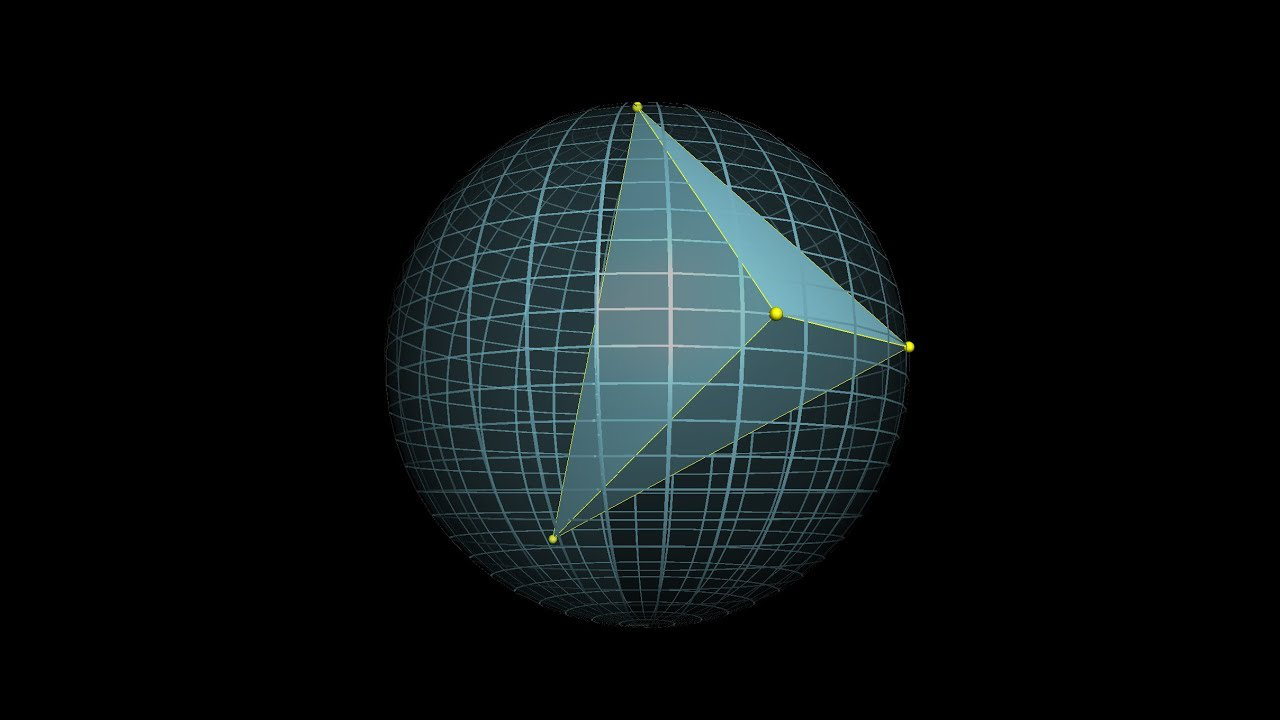

In [101]:

dir = '/Users/juniverse/Desktop/pointcloud/VectorUniverse/Data/thumbnails/images/'

for i in range(2515):
    ch = data['Channel'][i]
    id = data['Id'][i]
    
    image_dir = f'{dir}{ch}/{id}.jpg'
    # print(image_dir)
    x_image = Image.open(image_dir)
    x_title = X_title[i]
    x_label = y[i]
    print(x_title,x_label)
    # x_image
    break
x_image    

In [ ]:
from torch.utils.data import DataLoader,Dataset

class customdata(Dataset):
    def __init__(self) -> None:
        super().__init__()
        

class Model(nn.Module):
    def __init__(self,) -> None:
        super().__init__()

In [102]:
import gradio as gr
import clip,torch
import requests
from PIL import Image
import numpy as np
import torch
from io import BytesIO

label = ["Science",
"News",
"Food",
"Blog",
"Tech",
"Informative",
"Comedy,Entertainment",
"Entertainment",
"Automobile",
"Tech,Informative",
"Automobile,Comedy",
"VideoGames",
"Food,Entertainment",
"Blog,Comedy",
"Comedy,Informative",
"Tech,Comedy",
"Comedy",
"Blog,Science",
"Blog,Entertainment",
"Entertainment,Comedy",
"Tech,News",
"Entertainment,Blog"]

# TODO: cosine sims

def cosine_sim(x_emb,label_emb : torch.tensor) -> torch.tensor: # vector -> scalar 
    x_emb = x_emb.view(512)
    
    scores = torch.dot(x_emb,label_emb[0].view(512)).view(1)
    
    for i in range(1,22):
        label_emb_i = label_emb[i].view(512)
        score = torch.dot(x_emb,label_emb_i)
        score = score.view(1)
        scores = torch.cat([scores,score],dim=0)
    return scores

# TODO: softmax
def softmax(img_sim):
    return torch.exp(img_sim) / torch.sum(torch.exp(img_sim))

# TODO: clip probs

def label_embedding(label:list) -> torch.tensor:
    """Gets the embedding values for the image."""
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-B/32", device=device)
    label_token = clip.tokenize(label).to(device)
    # torch.Size([22, 77])
    
    with torch.no_grad():
        # encoding
        label_features = model.encode_text(label_token)
        # torch.Size([# of text, 512] 22
    return label_features

label_features = label_embedding(label)

def clip_probs(jpg,text,jpg_type=0):
    global label_features
    
    """Gets the embedding values for the image."""
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-B/32", device=device)
    
    if jpg_type==0:
        
        response = requests.get(jpg)
        image_bytes = response.content
        
        #Url 이미지 전처리.
        preprocess_image = preprocess(Image.open(BytesIO(image_bytes))).unsqueeze(0).to(device)
        # torch.Size([1, 3, 224, 224])
        
    else:
        # 디텍토리 jpg 이미지 처리
        # ex .../CLIP.jpg
        preprocess_image = preprocess(Image.open(jpg)).unsqueeze(0).to(device) 

    # 텍스트 tokenize
    text_token = clip.tokenize(text).to(device)
    # torch.Size([7, 77])

    # output.dtype : torch.float32
    with torch.no_grad():
        # encoding
        image_features = model.encode_image(preprocess_image)
        # torch.Size([# of img, 512]  1
        text_features = model.encode_text(text_token)
        # torch.Size([# of text, 512] 1
        
        # logits_per_image, logits_per_text = model(preprocess_image,text_token)
        # probs = logits_per_image.softmax(dim=-1).cpu().numpy()
        # print('labels probability',probs)
        
        
        ## similarity of image
        img_sim = cosine_sim(image_features,label_features)
        text_sim = cosine_sim(text_features,label_features)    

        # return text_features,image_features,probs


    #img_probs = label[torch.argmax(softmax(img_sim))]
    #text_probs = label[torch.argmax(softmax(text_sim))]
    # print(f'image similarity : {img_probs}')
    # print(f'text similarity : {text_probs}')
    
    #return img_probs,text_probs

    
    ##### TOP K #######
    
    topk = 3
    #torch.topk output types
    #torch.return_types.topk(
    #values=tensor([1.7843, 1.6211, 1.4115]),
    #indices=tensor([7, 8, 0])),

    img_topk_probs = list(torch.topk(softmax(img_sim),k=topk)[0].numpy())  # list 로 바꾸기
    text_topk_probs = list(torch.topk(softmax(text_sim),k=topk)[0].numpy()) #
    
    img_topk_index = torch.topk(softmax(img_sim),k=topk)[1]
    text_topk_index = torch.topk(softmax(text_sim),k=topk)[1]
    
    img_topk_cat = [label[img_topk_index[i]] for i in range(topk)]
    text_topk_cat = [label[text_topk_index[i]] for i in range(topk)]
    
    img_result = {'probs':img_topk_probs,'cat':img_topk_cat}
    text_result = {'probs':text_topk_probs,'cat':text_topk_cat}
    return img_result,text_result



# thumbnail data를 통한 성능 체크

In [30]:


import gradio as gr
import clip,torch
import requests
from PIL import Image
import numpy as np
import torch
from io import BytesIO



dir = '/Users/juniverse/Desktop/pointcloud/VectorUniverse/Data/thumbnails/images/'
counts = 0
img_counts = 0
text_counts = 0
total =  2515
total = 3

from tqdm import tqdm

result_dict = {}

for i in tqdm(range(80,90)):
    # print(f'{i}번째 입니다!')
    ch = data['Channel'][i]
    id = data['Id'][i]
    cat = data['Category'][i]
    cat_index = data['cat_code'][i]
    
    x_image_dir = f'{dir}{ch}/{id}.jpg'
    # print(image_dir)
    # x_image = Image.open(x_image_dir) # jpg
    x_title = X_title[i][:43] # text
    x_label = y[i] # label 
    # print(x_title,x_label)
    try:
        img_prob, text_prob = clip_probs(x_image_dir,x_title,jpg_type=1)
        # img_result, text_result= clip_probs(x_image_dir,x_title,jpg_type=1)
        
        
        # print('########                                 정답',label[x_label])
        # print()
        print('image: ',img_prob)
        print('text: ',text_prob)
        print('label:',cat)
        # 정답이 얼마나 맞는지 count
        aa=False
        bb=False
        
        if img_prob==label[x_label]:
            img_counts+=1
            aa=True
        if text_prob==label[x_label]:
            text_counts+=1
            bb=True
        
        if aa or bb:
            counts+=1
    except:
        print('error!')
        


  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:41,  4.63s/it]

image:  {'probs': [0.21244343, 0.20026536, 0.19593243], 'cat': ['Food,Entertainment', 'Food', 'Blog']}
text:  {'probs': [nan, nan, nan], 'cat': ['Science', 'News', 'Food']}
label: Food


 20%|██        | 2/10 [00:08<00:35,  4.46s/it]

image:  {'probs': [0.532486, 0.11371217, 0.0855876], 'cat': ['Blog,Comedy', 'Blog,Entertainment', 'Blog,Science']}
text:  {'probs': [0.3776695, 0.30346596, 0.15068111], 'cat': ['Blog,Comedy', 'Comedy', 'Blog,Science']}
label: Food


 30%|███       | 3/10 [00:13<00:31,  4.43s/it]

image:  {'probs': [0.314955, 0.20249408, 0.16844024], 'cat': ['Blog,Comedy', 'Food,Entertainment', 'Blog,Entertainment']}
text:  {'probs': [0.39078817, 0.32171118, 0.17052093], 'cat': ['Comedy', 'Blog,Comedy', 'Entertainment,Comedy']}
label: Food


 40%|████      | 4/10 [00:17<00:26,  4.40s/it]

image:  {'probs': [0.2925821, 0.26073962, 0.13934496], 'cat': ['Blog,Science', 'Blog,Comedy', 'Food,Entertainment']}
text:  {'probs': [0.637721, 0.17169136, 0.092733674], 'cat': ['Comedy', 'Entertainment,Comedy', 'Blog,Comedy']}
label: Food


 50%|█████     | 5/10 [00:22<00:21,  4.38s/it]

image:  {'probs': [0.3839918, 0.24191007, 0.12384295], 'cat': ['Blog', 'Blog,Comedy', 'Blog,Science']}
text:  {'probs': [nan, nan, nan], 'cat': ['Science', 'News', 'Food']}
label: Food


 60%|██████    | 6/10 [00:26<00:17,  4.40s/it]

image:  {'probs': [0.38214955, 0.1659446, 0.16416809], 'cat': ['Blog', 'Food', 'Food,Entertainment']}
text:  {'probs': [nan, nan, nan], 'cat': ['Science', 'News', 'Food']}
label: Food


 70%|███████   | 7/10 [00:30<00:13,  4.39s/it]

image:  {'probs': [0.22913815, 0.22275053, 0.2039782], 'cat': ['Blog,Comedy', 'Food', 'Blog,Science']}
text:  {'probs': [0.62295973, 0.17092603, 0.11456536], 'cat': ['Comedy', 'Entertainment,Comedy', 'Blog,Comedy']}
label: Food


 80%|████████  | 8/10 [00:35<00:08,  4.38s/it]

image:  {'probs': [0.4876446, 0.16059723, 0.13270144], 'cat': ['Blog,Comedy', 'Blog', 'Comedy,Informative']}
text:  {'probs': [nan, nan, nan], 'cat': ['Science', 'News', 'Food']}
label: Blog


 90%|█████████ | 9/10 [00:39<00:04,  4.37s/it]

image:  {'probs': [0.44497177, 0.18841468, 0.12349964], 'cat': ['Blog,Comedy', 'VideoGames', 'Blog']}
text:  {'probs': [nan, nan, nan], 'cat': ['Science', 'News', 'Food']}
label: Blog


100%|██████████| 10/10 [00:44<00:00,  4.40s/it]

image:  {'probs': [0.2045079, 0.13812171, 0.12690145], 'cat': ['Blog', 'Food,Entertainment', 'Blog,Science']}
text:  {'probs': [nan, 0.0, 0.0], 'cat': ['Blog', 'News', 'Food']}
label: Blog


In [56]:
data['img_top1_cat'] = 'None'
data['img_top2_cat'] = 'None'
data['img_top3_cat'] = 'None'
data['img_top1_prob'] = 0
data['img_top2_prob'] = 0
data['img_top3_prob'] = 0

data['text_top1_cat'] = 'None'
data['text_top2_cat'] = 'None'
data['text_top3_cat'] = 'None'
data['text_top1_prob'] = 0
data['text_top2_prob'] = 0
data['text_top3_prob'] = 0
data

In [47]:
data.to_csv('ex.csv')
data.to_json('ex.json')

In [60]:


import gradio as gr
import clip,torch
import requests
from PIL import Image
import numpy as np
import torch
from io import BytesIO



dir = '/Users/juniverse/Desktop/pointcloud/VectorUniverse/Data/thumbnails/images/'
counts = 0
img_counts = 0
text_counts = 0
total =  2515
total = 3

from tqdm import tqdm

result_dict = {}
counts = 0

channels = {}

for i in list(data.Channel.unique()): # channel's name
    channels[i] = {'total':0,'counts':0,'img_counts':0,'text_counts':0}

for i in tqdm(range(5)):
    # print(f'{i}번째 입니다!')
    ch = data['Channel'][i]
    id = data['Id'][i]
    cat = data['Category'][i]
    cat_index = data['cat_code'][i]
    
    x_image_dir = f'{dir}{ch}/{id}.jpg'
    # print(image_dir)
    # x_image = Image.open(x_image_dir) # jpg
    x_title = X_title[i] # text
    x_label = y[i] # label 
    
    try:
        img_result, text_result= clip_probs(x_image_dir,x_title,jpg_type=1)
        #img_result = {'probs':img_topk_probs,'cat':img_topk_cat}
        
        #topk까지 맞는지 확인
        img_topk = False
        text_topk = False
        
        print('image',img_result)
        print('text',text_result)
        print('label',cat)
        print()
        
        ########### counts ###############
        # images
        if cat in img_result['cat']:
            img_topk = True
            channels[ch]['img_counts']+=1
        
        # text
        if cat in text_result['cat']:
            text_topk = True
            channels[ch]['text_counts']+=1
            
        # total
        if img_topk or text_topk:
            counts+=1        
            channels[ch]['counts']+=1
            
        ######## data ##############
        
        # image top cat & prob

        data['img_top1_cat'][i] = img_result['cat'][0]
        data['img_top2_cat'][i] = img_result['cat'][1]
        data['img_top3_cat'][i] = img_result['cat'][2]
        data['img_top1_prob'][i] = img_result['probs'][0]
        data['img_top2_prob'][i] = img_result['probs'][1]
        data['img_top3_prob'][i] = img_result['probs'][2]

        ## text top cat & prob
        data['text_top1_cat'][i] = text_result['cat'][0]
        data['text_top2_cat'][i] = text_result['cat'][1]
        data['text_top3_cat'][i] = text_result['cat'][2]
        data['text_top1_prob'][i] = text_result['probs'][0]
        data['text_top2_prob'][i] = text_result['probs'][1]
        data['text_top3_prob'][i] = text_result['probs'][2]

            
    except:
        print('no data error!')

  0%|          | 0/5 [00:00<?, ?it/s]

/var/folders/j9/psjfyfss16v_xrrj6mh5sw0h0000gn/T/ipykernel_21340/253106659.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['img_top1_cat'][i] = img_result['cat'][0]
/var/folders/j9/psjfyfss16v_xrrj6mh5sw0h0000gn/T/ipykernel_21340/253106659.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['img_top2_cat'][i] = img_result['cat'][1]
/var/folders/j9/psjfyfss16v_xrrj6mh5sw0h0000gn/T/ipykernel_21340/253106659.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

image {'probs': [0.74610126, 0.10743647, 0.045785867], 'cat': ['Blog,Science', 'Science', 'Blog']}
text {'probs': [nan, nan, nan], 'cat': ['Science', 'News', 'Food']}
label Science



/var/folders/j9/psjfyfss16v_xrrj6mh5sw0h0000gn/T/ipykernel_21340/253106659.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['img_top1_cat'][i] = img_result['cat'][0]
/var/folders/j9/psjfyfss16v_xrrj6mh5sw0h0000gn/T/ipykernel_21340/253106659.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['img_top2_cat'][i] = img_result['cat'][1]
/var/folders/j9/psjfyfss16v_xrrj6mh5sw0h0000gn/T/ipykernel_21340/253106659.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

image {'probs': [0.60534686, 0.31697208, 0.03073006], 'cat': ['Blog,Science', 'Science', 'Blog,Comedy']}
text {'probs': [nan, nan, 0.0], 'cat': ['Science', 'Blog,Science', 'Food']}
label Science



/var/folders/j9/psjfyfss16v_xrrj6mh5sw0h0000gn/T/ipykernel_21340/253106659.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['img_top1_cat'][i] = img_result['cat'][0]
/var/folders/j9/psjfyfss16v_xrrj6mh5sw0h0000gn/T/ipykernel_21340/253106659.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['img_top2_cat'][i] = img_result['cat'][1]
/var/folders/j9/psjfyfss16v_xrrj6mh5sw0h0000gn/T/ipykernel_21340/253106659.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

image {'probs': [0.48971257, 0.10031966, 0.06695719], 'cat': ['Blog,Science', 'Tech,News', 'Blog,Comedy']}
text {'probs': [nan, nan, nan], 'cat': ['Science', 'News', 'Food']}
label Science



/var/folders/j9/psjfyfss16v_xrrj6mh5sw0h0000gn/T/ipykernel_21340/253106659.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['img_top1_cat'][i] = img_result['cat'][0]
/var/folders/j9/psjfyfss16v_xrrj6mh5sw0h0000gn/T/ipykernel_21340/253106659.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['img_top2_cat'][i] = img_result['cat'][1]
/var/folders/j9/psjfyfss16v_xrrj6mh5sw0h0000gn/T/ipykernel_21340/253106659.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

image {'probs': [0.75673646, 0.082634315, 0.04287952], 'cat': ['Blog,Science', 'Tech,Informative', 'Tech,News']}
text {'probs': [nan, nan, nan], 'cat': ['Science', 'News', 'Food']}
label Science



/var/folders/j9/psjfyfss16v_xrrj6mh5sw0h0000gn/T/ipykernel_21340/253106659.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['img_top1_cat'][i] = img_result['cat'][0]
/var/folders/j9/psjfyfss16v_xrrj6mh5sw0h0000gn/T/ipykernel_21340/253106659.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['img_top2_cat'][i] = img_result['cat'][1]
/var/folders/j9/psjfyfss16v_xrrj6mh5sw0h0000gn/T/ipykernel_21340/253106659.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

image {'probs': [0.5565319, 0.25448126, 0.07925101], 'cat': ['Blog,Science', 'Science', 'Informative']}
text {'probs': [nan, nan, nan], 'cat': ['Science', 'News', 'Food']}
label Science



In [61]:
data



,Id,Channel,Category,Title,cat_code,img_top1_cat,img_top2_cat,img_top3_cat,img_top1_prob,img_top2_prob,img_top3_prob,text_top1_cat,text_top2_cat,text_top3_cat,text_top1_prob,text_top2_prob,text_top3_prob
0,OkmNXy7er84,3Blue1Brown,Science,The hardest problem on the hardest test,0,"Blog,Science",Science,Blog,0.746101,0.107436,0.045786,Science,News,Food,NaN,NaN,NaN
1,r6sGWTCMz2k,3Blue1Brown,Science,But what is a Fourier series? From heat flow t...,0,"Blog,Science",Science,"Blog,Comedy",0.605347,0.316972,0.030730,Science,"Blog,Science",Food,NaN,NaN,0.0
2,bBC-nXj3Ng4,3Blue1Brown,Science,But how does bitcoin actually work?,0,"Blog,Science","Tech,News","Blog,Comedy",0.489713,0.100320,0.066957,Science,News,Food,NaN,NaN,NaN
3,aircAruvnKk,3Blue1Brown,Science,"But what is a neural network? | Chapter 1, Dee...",0,"Blog,Science","Tech,Informative","Tech,News",0.756736,0.082634,0.042880,Science,News,Food,NaN,NaN,NaN
4,HEfHFsfGXjs,3Blue1Brown,Science,The most unexpected answer to a counting puzzle,0,"Blog,Science",Science,Informative,0.556532,0.254481,0.079251,Science,News,Food,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2510,In0nB0ABaUk,Web Dev Simplified,Tech,JavaScript Form Validation,4,None,None,None,0.000000,0.000000,0.000000,None,None,None,0.0,0.0,0.0
2511,y17RuWkWdn8,Web Dev Simplified,Tech,Learn DOM Manipulation In 18 Minutes,4,None,None,None,0.000000,0.000000,0.000000,None,None,None,0.0,0.0,0.0
2512,O6P86uwfdR0,Web Dev Simplified,Tech,Learn useState In 15 Minutes - React Hooks Exp...,4,None,None,None,0.000000,0.000000,0.000000,None,None,None,0.0,0.0,0.0
2513,DUg2SWWK18I,Web Dev Simplified,Tech,MVC Explained in 4 Minutes,4,None,None,None,0.000000,0.000000,0.000000,None,None,None,0.0,0.0,0.0


### channel 별로 정답률 확인



# gradio 를 통한 시각화

In [3]:
import gradio as gr
import clip,torch
import requests
from PIL import Image
import numpy as np
import torch
from io import BytesIO



def get_clip_image_description(url = 'https://i.pinimg.com/564x/47/b5/5d/47b55de6f168db65cf46d7d1f0451b64.jpg',text =["a diagram", "a dog", "a cat",'notebook','room','door','computer']):
    response = requests.get(url)
    image_bytes = response.content

    """Gets the embedding values for the image."""
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-B/32", device=device)

    # 저장되어 있는 이미지로 임베딩.
    # image = preprocess(Image.open("CLIP.png")).unsqueeze(0).to(device) 
    
    #저장되지않은 이미지로 임베딩
    image = preprocess(Image.open(BytesIO(image_bytes))).unsqueeze(0).to(device)
    
    text = clip.tokenize(text).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)
        
        logits_per_image, logits_per_text = model(image,text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    print('labels probability',probs)
    # return text_features,image_features,probs
    return probs

# text_emb,img_emb,probs = get_clip_image_description(url)


with gr.Blocks() as demo:
    gr.Markdown('filp text or image files using this demo')
    with gr.Tab('flip text'):
        name = gr.Textbox(label='Name of yours')
        output = get_clip_image_description(name)
        output = gr.Textbox(label='Output Box')
        greet_btn = gr.Button('Greet')
        
    with gr.Tab('filp image'):
        with gr.Row():
            img_input = gr.Image()
            img_output = gr.Image()
        img_btn = gr.Button('img flip')
    
    with gr.Accordion('open for more!'):
        gr.Markdown('look at me...')
    
    greet_btn.click(
        fn=greet, 
        inputs= name,
        # inputs = ['text','checkbox',gr.Slider(0,100)],
        outputs=output)
    
    
    img_btn.click(fn=greet_img, inputs=img_input, outputs=img_output)


# demo.launch(share=True)
# demo.launch()


# 출력으로 원하는것. 

# default label.
# 내가 만든 라벨 custom label.

# 여기에 부합하는 것들 출력. 

# 1번째 버전은 result를 넣으면 그게 어떻게 나오는지 판단하는 기계, 참 거짓 보기.

# 2번째 버전은 result를 넣으면 그것과 비슷한것들이 나오는지 판단.

MissingSchema: Invalid URL 'textbox': No scheme supplied. Perhaps you meant https://textbox?

# 모델링

In [ ]:
## data get

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim 

import pandas as pd
import numpy
import matplotlib.pyplot as plt

## read title and make pairs

df = pd.read_csv('/Users/juniverse/Desktop/pointcloud/VectorUniverse//Data/Youtube_thumbnails/metadata.csv')


# 이미지에 해당하는 데이터 가져오기.

## design arichtecture

# Image encoder ( Vit/s ) 

# Text encoder ( BERT/s )

# objective function

# contastive learning

import torch

# Create a real tensor for the imaginary part
imaginary_tensor = torch.zeros_like(a)

# Convert the real and imaginary tensors to a complex number
complex_tensor = torch.complex(a, imaginary_tensor)

# Print the complex tensor
print(complex_tensor)


val,vec = torch.linalg.eig(a)

complex_tensor@vec

df.tail()